# NIST Digit Classification: Principal Components Analysis

### Table of Contents

* Introduction
 * PCA
 * Handwritten Digits Data Set
* Load the Data
* Normalizing the Data
* Analyzing the Data
 * Covariance Matrix
 * Eigenvectors and Eigenvalues of Covariance Matrix
 * Explanation of Variance
* Four Component PCA
 * Building a PCA Model: 4 Components
 * Assessing a PCA Model: Explained Variance
 * Projection Into Feature Subspace: By Hand
 * Projection Into Feature Subspace: With Scikit-Learn
 * Assessing a PCA Model: Reconstruction Error and Back-Projection
* Conclusion

## Introduction

### About This Notebook

In this notebook we illustrate the implementation of principal component analysis for dimensionality reduction of a basic image data set using both directly, using linear algebra tools, and using scikit-learn's PCA object.

### Handwritten Digits Data Set

The data set we wil be analyzing is a data set for handwriting recognition: each observation corresponds to an 8 by 8 grid indicating intensity. (We'll see below that we can recreate the image using the matplotlib `imshow()` function.) The intention is to map the 64 input variables (corresponding to pixel intensities on the 8x8 grid) to a categorical system response quantity (0 through 9). Principal component analysis does _not_ make these types of mappings or predictions, however; PCA will project the inputs from 64-dimensional space onto a smaller space, thus reducing the cost of the problem and opening up more machine learning approaches.

### PCA

Principal compnents analysis is a mapping from the original, high-dimensional space of $d$ input variables to a lower-dimensional subspace of $k$ variables. The intention is to minimize the loss of information (to maximize the amount of variance in the data explained by the principal components, while minimizing the number of principal components). 

It is important to note that PCA is a dimensionality reduction technique; it does not use the outputs. PCA is used to lower the dimensionality, and is thus combined with other machine-learning techniques that can use the lower-dimensional set of input variables.

In linear algebra terms, we are projecting an input vector $\mathbf{X}$ to a reduced input vector $\mathbf{Z}$ using a projection matrix $\mathbf{W}$:

$$
\mathbf{Z} = \mathbf{W}^{T} \mathbf{X}
$$

The construction of the projection matrix is based on a maximization problem: maximizing the variance explained by each principal component. The principal component is $\mathbf{W}_1$, a vector of length $d$, and is a weighted combination of input variables which, after the data is projected onto $\mathbf{W}_1$, spreads the data out the most.

The optimization problem thus becomes: for a given observation $i$, maximize the variance of the vector $Z_i$, which is equal to:

$$
Var(\mathbf{Z}_i) = \mathbf{W}_i^{T} \Sigma \mathbf{W}_i
$$

while constraining the L2 norm of each projection vector to be 1,

$$
\mathbf{W}_i^{T} \mathbf{W}_i = 1
$$

This boils down to a few linear algebra operations, which we'll do by hand, and then with scikit-learn's PCA object.

In [2]:
%matplotlib inline

# numbers
import numpy as np
import pandas as pd

# stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# plots
import matplotlib.pyplot as plt
import seaborn as sns

# utils
import os, re
from pprint import pprint

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Load the Data

Start by looking at the two files, `.tes` and `.tra`, containing test and training data, respectively:

In [3]:
print [j for j in os.listdir('data/optdigits')]

['optdigits-orig.cv.Z', 'optdigits.names', 'optdigits.tes', 'optdigits.tra']


Each file has 65 columns: 64 inputs (consisting of the optical image representing the hand-written character) and 1 response (which digit the hand-written character represents). Split both testing and training data into input matrix $\mathbf{X}$ and response vector $\mathbf{y}$. We'll only use the training data - we're not actually training any models here, just reducing dimensionality of the problem.

In [4]:
## No learning, no testing.
#testing_df = pd.read_csv('data/optdigits/optdigits.tes',header=None)
#X_testing,  y_testing  = testing_df.loc[:,0:63],  testing_df.loc[:,64]

training_df = pd.read_csv('data/optdigits/optdigits.tra',header=None)
X_training, y_training = training_df.loc[:,0:63], training_df.loc[:,64]

In [5]:
print X_training.shape
print y_training.shape

(3823, 64)
(3823,)


The 64 inputs consist of an 8x8 image, which we can actually look at ourselves using matplotlib's `imshow()` function:

[[ 0  1  6 15 12  1  0  0]
 [ 0  7 16  6  6 10  0  0]
 [ 0  8 16  2  0 11  2  0]
 [ 0  5 16  3  0  5  7  0]
 [ 0  7 13  3  0  8  7  0]
 [ 0  4 12  0  1 13  5  0]
 [ 0  0 14  9 15  9  0  0]
 [ 0  0  6 14  7  1  0  0]]


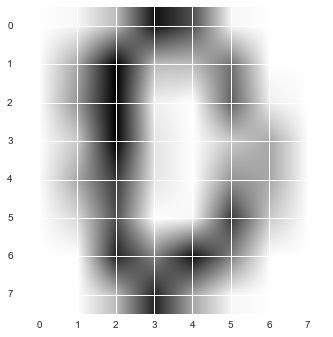

In [6]:
mat = X_training.loc[0,:].reshape(8,8)
print mat
plt.imshow(mat)
plt.show()

## Normalizing the Data

Our input data is a bit messy - 8x8 grids of integer values with a non-standard scale. It is useful to scale the input variables, using a scikit-learn `StandardScaler` object. This will scale the variables so that they have a zero mean and a standard deviation of approximately 1.

Here is a method that takes a matrix of input variables as a parameter, and returns the standardized inputs matrix, a mean value for the inputs, and a covariance matrix:

In [7]:
def get_normed_mean_cov(X):
    X_std = StandardScaler().fit_transform(X)
    X_mean = np.mean(X_std, axis=0)
    
    ## Automatic:
    #X_cov = np.cov(X_std.T)
    
    # Manual:
    X_cov = (X_std - X_mean).T.dot((X_std - X_mean)) / (X_std.shape[0]-1)
    
    return X_std, X_mean, X_cov

X_std, X_mean, X_cov = get_normed_mean_cov(X_training)

Note that by scaling our input variables, we save ourselves a little work when we project the high-dimensional inputs to their corresponding low-dimensional PCA subspace.

## Analyzing the Data

### Covariance Matrix

Now that we have the covariance matrix, we can visualize it. This tells us about the covariance between different pixels in the 8x8 images. We visually see the structure of the 8x8 images - images that are on opposite ends of the image have negative covariances, which means they are likely to be on opposite sides of the above average/below average scale. Recall the definition of covariance:

$$
Cov(\psi,\phi) = \sum_{i=1}^{N} \dfrac{ \left( \psi_i - \overline{\psi} \right) \left( \phi_i - \overline{\phi} \right) }{ N }
$$


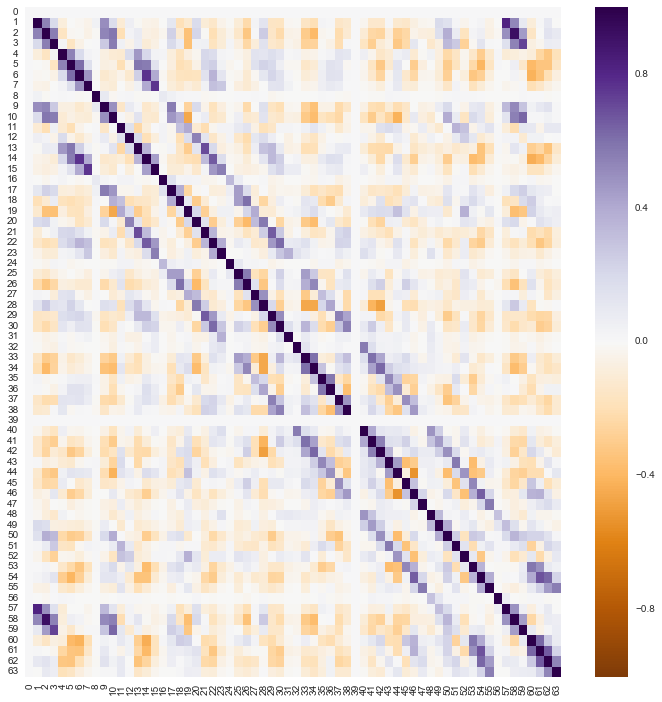

In [8]:
fig = plt.figure(figsize=(12,12))
sns.heatmap(pd.DataFrame(X_cov), annot=False, cmap='PuOr')
plt.show()

The problem of finding the principal components was expressed above as an optimization problem. This optimization problem can be converted into a Lagrange multipliers problem, and solved by computing the eigenvalues and eigenvectors of the covariance matrix.

Thus, the eigenvalues and eigenvectors of the covariance matrix yield the principal components.

### Eigenvectors and Eigenvalues of Covariance Matrix

No good engineering mathematics course is complete without a dash of eigenvectors and eigenvalues - enough to make the students want to tear their hair out, and no less. The topic is useful in studying the behavior of systems, as the eigenvalues represent the characteristic values of a matrix system, and can be used in many different ways. The eigenvectors and eigenvalues of the covariance matrix will give the principal components and a vector that we can use to project high-dimensional inputs to the lower-dimensional subspace.

In [9]:
eigenvals, eigenvecs = np.linalg.eig(X_cov)

# Eigenvalues are not necessarily sorted, but eigenval[i] *does* correspond to eigenvec[i]

print "Eigenvals shape: "+str(eigenvals.shape)
print "Eigenvecs shape: "+str(eigenvecs.shape)

Eigenvals shape: (64,)
Eigenvecs shape: (64, 64)


In [10]:
# Create a tuple of (eigenvalues, eigenvectors)
unsrt_eigenvalvec = [(np.abs(eigenvals[i]), eigenvecs[:,i]) for i in range(len(eigenvals))]

# Sort tuple by eigenvalues
eigenvalvec = sorted(unsrt_eigenvalvec, reverse=True, key=lambda x:x[0])

#pprint([pair for pair in eigenvalvec])

We can visualize the eigenvectors, sorted by eigenvalue rank, and visually identify which eigenvector components dominate in each eigenvalue. This is essentially a visualization of what information the principal component analysis has judged most important.

Note we're doing this all a bit on-the-fly - a list comprehension is looping over the first 21 eigenvalue-eigenvector pairs, which have been sorted above, and grabbing the eigenvector (`pair[1]`). This is all being stuffed into a DataFrame, and everything slapped together for a nice fancy visualization. This is mainly because we have no particularly meaningful labels for the 64 input components.

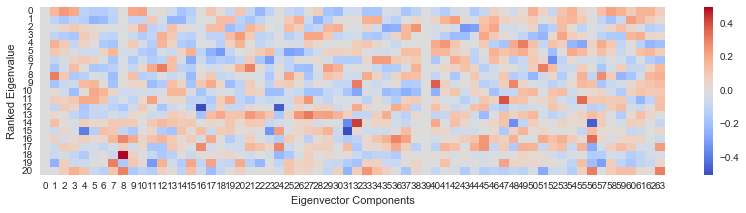

In [11]:
fig = plt.figure(figsize=(14,3))
sns.heatmap(pd.DataFrame([pair[1] for pair in eigenvalvec[0:21]]), 
            annot=False, cmap='coolwarm',
           vmin=-0.5,vmax=0.5)

plt.ylabel("Ranked Eigenvalue")
plt.xlabel("Eigenvector Components")
plt.show()

More of the cyclic structure of the images present in the above heatmap. The spots of high and low values indicate there may be a few values where the presence of a pixel is a strong indicator that a number is or is not a certain digit. For example, the digit 8 should have holes in the top and bottom. Supposing the 8 is legible, there are only one or two pixels where the holes can go, so the presence or absence of color can be a strong indicator for a single digit.

### Explanation of Variance

To measure the "principalness" of each principal component - how important it is - we can determine how much of the variance in the data it explains. (Note that we say variance here because representing the data using the mean is considered the baseline against which everything else is compared. (This is the same idea behind Pearson's R squared coefficient.) If more variance - variation from the mean - in the data can be explained by the model, the model is better.

The individual explained variance of principal component $k$ is denoted $\lambda_{k}$. 

The explained variance of the $k^{th}$ principal component (given $d$ total principal components) is given by:

$$
\frac{  \lambda_1 + \lambda_2 + \dots + \lambda_k }{ \lambda_1 + \lambda_2 + \dots + \lambda_{k} + \dots + \lambda_{d}}
$$

We'll start by calculating individual explained variances, $\lambda_{k}$.

In [12]:
lam_sum = sum(eigenvals)
explained_variance = [(lam_k/lam_sum) for lam_k in sorted(eigenvals, reverse=True)]

The distribution of explained variance for each principal component gives a sense of how much information will be represented and how much lost when the full, 64-dimensional input is reduced using a principal component model (i.e., a model that utilizes only the first $N$ principal components).

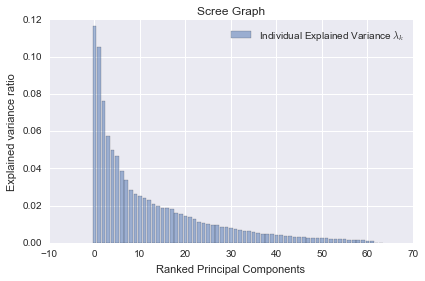

In [13]:
plt.figure(figsize=(6, 4))

plt.bar(range(len(explained_variance)), explained_variance, alpha=0.5, align='center',
        label='Individual Explained Variance $\lambda_{k}$')

plt.ylabel('Explained variance ratio')
plt.xlabel('Ranked Principal Components')
plt.title("Scree Graph")

plt.legend(loc='best')
plt.tight_layout()

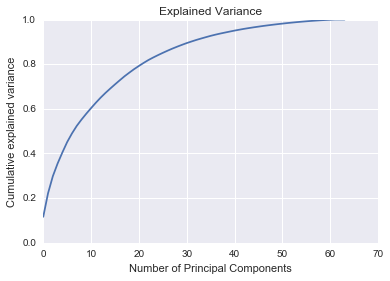

In [14]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)

ax1.plot(np.cumsum(explained_variance))

ax1.set_ylim([0,1.0])

ax1.set_xlabel('Number of Principal Components')
ax1.set_ylabel('Cumulative explained variance')
ax1.set_title('Explained Variance')

plt.show()

Our intention with the princpal component analysis is to reduce the high-dimensional input to a low-dimensional input. Ultimately that low-dimensional input is intended for use in a model, which we'll train using the training data and test using the testing data.

We'll start by specifying how many of the 64 principal components we want our model to keep. Adding more components increases the cost and the accuracy. Start with a few, go from there.

## Four-Component PCA

### Building a PCA Model: 4 Components

Start by creating a PCA model that uses only 4 principal components, a major reduction in number of dimensions:

In [15]:
# This is a little easier to do by just using the PCA class from scikit-learn.
# But that isn't as fun as doing everything by hand.
sklearn_pca = PCA(n_components=4).fit(X_std)

Once the PCA model has been fit to the inputs, we can obtain various quantities to see what the four principal components look like. For example, to see the contributions of each of the 64 input variables to the 1st principal component, use the `components_` field of the PCA object:

In [16]:
print sklearn_pca.components_.shape

(4, 64)


In [17]:
print "Principal Components:"
print sklearn_pca.components_

Principal Components:
[[ -1.56196384e-18  -1.60866695e-01  -2.48610786e-01  -2.06309722e-01
    1.11112869e-01   1.33766707e-01   1.41239656e-01   1.01476093e-01
   -7.90888742e-03  -2.14417687e-01  -2.27923284e-01   1.04202882e-02
   -2.69297989e-02   5.70502201e-02   1.78713816e-01   1.28794923e-01
   -4.64469011e-03  -1.27951196e-01  -2.69804127e-02   7.62983580e-02
   -1.17227511e-01   8.09241217e-02   2.19642225e-01   1.13217881e-01
   -5.32038442e-04   7.07536884e-02   1.15030418e-01  -1.09639054e-02
   -8.31026096e-02   1.72864885e-01   2.03927827e-01   4.93102367e-02
    4.84464877e-02   1.71987700e-01   1.67406577e-01   2.13447735e-02
    3.14567249e-02   1.65939213e-01   1.06911434e-01   0.00000000e+00
    7.68894866e-02   1.36242972e-01   4.57839222e-02   2.20165005e-02
    1.51517101e-01   8.06661590e-02  -8.02013392e-02  -1.80371919e-02
    4.78544777e-02  -3.96819365e-02  -1.89776347e-01  -6.59699405e-02
    7.95574312e-02  -1.24824925e-01  -1.84684450e-01  -6.05132917e-0

Likewise a bar plot of the components can show which variables have the heaviest weights in which principal component:

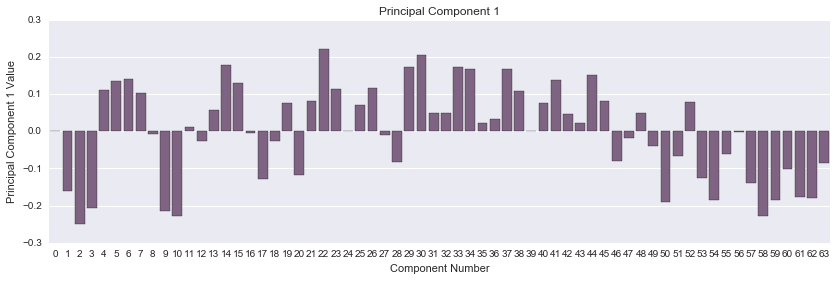

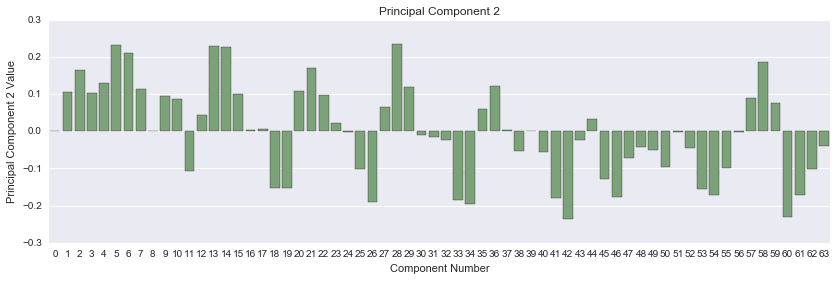

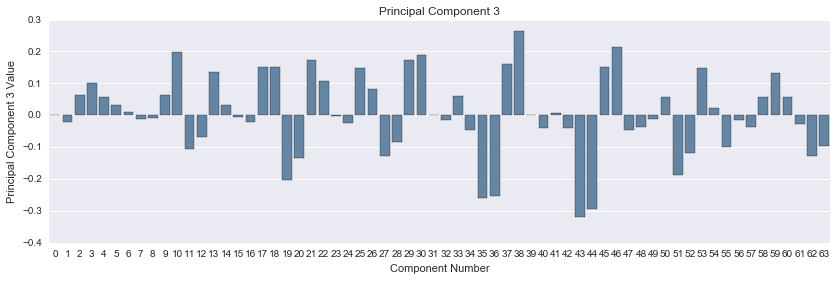

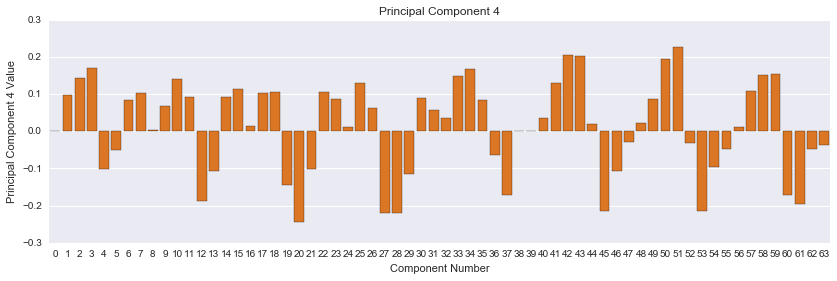

In [18]:
colors = [sns.xkcd_rgb[z] for z in ['dusty purple','dusty green','dusty blue','orange']]
for i in range(4):
    fig = plt.figure(figsize=(14,4))
    sns.barplot(range(len(sklearn_pca.components_[i])), sklearn_pca.components_[i], color=colors[i])
    plt.xlabel('Component Number')
    plt.ylabel('Principal Component '+str(i+1)+' Value')
    plt.title('Principal Component '+str(i+1))
    plt.show()

Turning the principal component vector from a vector of length 64 to an 8x8 matrix reveals an interesting visual representation of the principal components:

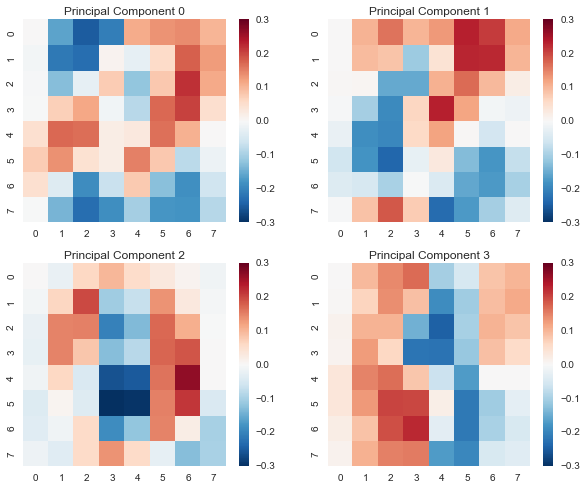

In [19]:
fig = plt.figure(figsize=(10,8))
axes = [fig.add_subplot(220+i+1) for i in range(4)]

for i,ax in enumerate(axes):
    sns.heatmap(sklearn_pca.components_[i].reshape(8,8), 
                square=True, ax=ax, 
                vmax = 0.30, vmin=-0.30)
    ax.set_title('Principal Component '+str(i))
    #ax.set_xlabel('Horz Pixels')
    #ax.set_ylabel('Vert Pixels')
    
plt.show()

Because each of the components represents a pixel in an image, the above heatmaps show a visual map of which pixels are important in which principal components.

### Assessing a PCA Model: Explained Variance

We know right now that 4 components is going to give an extremely crummy model. That's like saying we could get the gist of a book by picking out 3 words from each page. But how bad will it be? Surprisingly, it would explain _almost_ 50% of the variance. From the explained variance vector:

In [20]:
print np.cumsum(explained_variance)[4]

0.404619162875


Here's a list comprehension that loops over each element in explained variance, and creates a table of how many components are needed to explain a certain amount of the variance. This table can be used to pick a number of components based on an amount of variance explained. 

If we select N principal components, how much of the variance will be explained?
* 7 principal components will explain > 50% of the variance.
* 18 principal components will explain > 75% of the variance.
* 25 principal components will explain 85% of the variance.
* 32 principal comopnents will explain 90% of the variance.

In [21]:
pprint([(j, np.cumsum(explained_variance)[j]) for j in range(len(explained_variance[:33]))])

[(0, 0.11639051881399594),
 (1, 0.22154845764447428),
 (2, 0.29781224518345339),
 (3, 0.35493186226131257),
 (4, 0.40461916287465743),
 (5, 0.45110020106004589),
 (6, 0.48964603639919019),
 (7, 0.52343654265721962),
 (8, 0.55194685589555759),
 (9, 0.57825601382791403),
 (10, 0.60329197026525538),
 (11, 0.62737887758602506),
 (12, 0.65016714626941419),
 (13, 0.67110291269662814),
 (14, 0.69066097180707353),
 (15, 0.70957009113735492),
 (16, 0.72800394709722849),
 (17, 0.74601323354097571),
 (18, 0.7622348008957186),
 (19, 0.77788614205399953),
 (20, 0.79213848304319334),
 (21, 0.80592182441609561),
 (22, 0.818808666436322),
 (23, 0.83009685968470004),
 (24, 0.84071210169140287),
 (25, 0.85083831448099134),
 (26, 0.86056534774678051),
 (27, 0.86986006912903302),
 (28, 0.87849331700688105),
 (29, 0.88673686171844546),
 (30, 0.8946141133636738),
 (31, 0.9017406940322803),
 (32, 0.90869566633708054)]


### Projection Into Feature Subspace: By Hand

To actually transform the high-dimensional 64-input points onto the lower-dimensional subspace of principal components (the new feature subspace), we're weighting each of the input variable values according to the eigenvector. This is done using a projection matrix, which is a matrix that is multiplied by the input vector to change its size into a smaller subspace.

For example, to transform a set of 64-dimensional input vectors $\mathbf{X}$ into their approximated 4-dimensional subspace versions $\mathbf{Z}$ using the projection matrix $\mathbf{W}$, we'll need to do the following matrix multiplication:

$$
\mathbf{Z} = \mathbf{W}^{T} \mathbf{X}
$$

where $\mathbf{W}^{T}$ is a $4 \times 64$ projection matrix, and $\mathbf{X}$ is a $64 \times N$ matrix of the original inputs (this is the transpose of what we have stored in the `X_std` variable).

This will result in a matrix $\mathbf{Z}$ that is of size $4 \times N$. This matrix can then be used as a reduced set of input variables, and a variety of other machine learning techniques can be applied. The expense of these techniques often increases as $O(N^2)$ or $O( N ln(N))$, so reducing 64 dimensions to 4 can lead to orders-of-magnitude decreases in the computational cost of machine learning models.

To use our own eignevectors/eigenvalues to create the projection matrix:

In [22]:
# Do it by hand first (we'll also see how to do this with the scikit-learn PCA object):
matW = np.hstack( pair[1].reshape(64,1) for pair in eigenvalvec[0:4] )
print matW.shape

(64, 4)


In [23]:
# There are two ways to use the projection matrix:

# This is the "easy" way. 
# This will make our projection reversed from scikit-learn,
# (flipped across one axis).
Z = X_std.dot(matW)

# This is the "correct" way.
# This projection will match scikit-learn's,
# But it also flips Xtilde.
#Xtilde = matW.T.dot(X_std.T)

print Z.shape

(3823, 4)


In [24]:
# To color each point by the digit it represents,
# create a color map with 10 elements (10 RGB values).
# Then, use the system response (y_training), which conveniently
# is a digit from 0 to 9.
def get_cmap(n):
    #colorz = plt.cm.cool
    colorz = plt.get_cmap('Set1')
    return [ colorz(float(i)/n) for i in range(n)]

colorz = get_cmap(10)
colors = [colorz[yy] for yy in y_training]

When we determine the explained variance due to each principal component, using a 4-component PCA, we have to use the total variance _of the four components_, not of the 64-dimensional explained variance calculated above. We account for this by computing the total variance as the sum of the explained variance of the first 4 components:

```python
total_variance = np.sum(explained_variance[0:n_components])
```

which makes the explained variances of each of the four components add up to 1. This also keeps us consistent with the definition of explained variance _for the PCA model we have selected_, and keeps us consistent with the scikit-learn implementation.

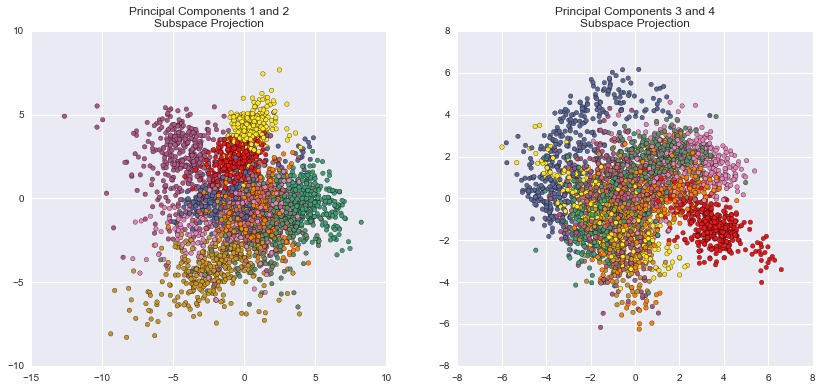

Explained Variance, Principal Component 0: 0.3279
Explained Variance, Principal Component 1: 0.2963
Explained Variance, Principal Component 2: 0.2149
Explained Variance, Principal Component 3: 0.1609


In [25]:
fig = plt.figure(figsize=(14,6))
ax1, ax2 = [fig.add_subplot(120 + i + 1) for i in range(2)]

ax1.scatter( Z[:,0], Z[:,1] , c=colors )
ax1.set_title('Principal Components 1 and 2\nSubspace Projection')

ax2.scatter( Z[:,2], Z[:,3] , c=colors )
ax2.set_title('Principal Components 3 and 4\nSubspace Projection')

plt.show()

n_components = 4
total_variance = np.sum(explained_variance[0:n_components])
for i in range(n_components):
    print("Explained Variance, Principal Component %d: %0.4f"%(i,explained_variance[i]/total_variance))

In [26]:
pairplot_df = pd.DataFrame(Z, columns=['Principal Component '+str(j) for j in range(Z.shape[1])])
pairplot_df.reindex(pairplot_df.columns.sort_values(ascending=True))
z_columns = pairplot_df.columns

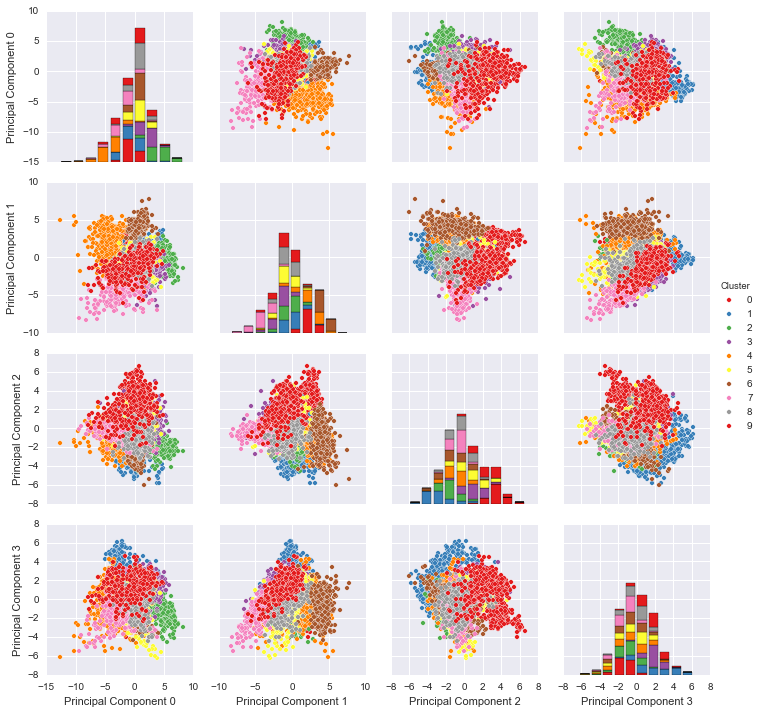

In [27]:
pairplot_df['Cluster'] = y_training
pairplot_df = pairplot_df.sort_values('Cluster',ascending=True)
sns.pairplot(pairplot_df, hue='Cluster', 
             vars=z_columns, # don't plot the category/system response
             palette='Set1')
plt.show()

How do we interpret this plot?

First, it's a pleasant surprises that even with a measly four principal components, the various points corresponding to various digits still cluster nicely - in some data sets, this is not so clear. The location of these points will compose a probability density function, which could be combined with probabilistic methods to produce a prediction of what digit a point comes from based on where it is located. 

The unfortunate thing about the plot is that the clusters are sitting on top of one another. More principal components, or other clustering techniques, can further differentiate these points, but with only four principal components, the explained variance is not high enough to segregate the clusters further.

### Projection Into Feature Subspace: With Scikit-Learn

We can repeat the same procedure with scikit-learn, projecting a set of high-dimensional inputs $\mathbf{X}$ to the low-dimensional subspace, yielding $\mathbf{Z}$:

In [28]:
# Now repeat the same process of projecting all 
# the high-dimensional inputs into a lower-dimensional 
# subspace, but using the scikit-learn PCA object:

scikit_Z = sklearn_pca.fit_transform(X_std)

In [29]:
print scikit_Z.shape
print Z.shape

(3823, 4)
(3823, 4)


The plots are identical, other than being reflected across the x-axis. (This was caused by arranging our data in transposed order, easier to visualize/manipulate, instead of the traditional linear-algebra order). Furthermore, the explained variances are identical as well:

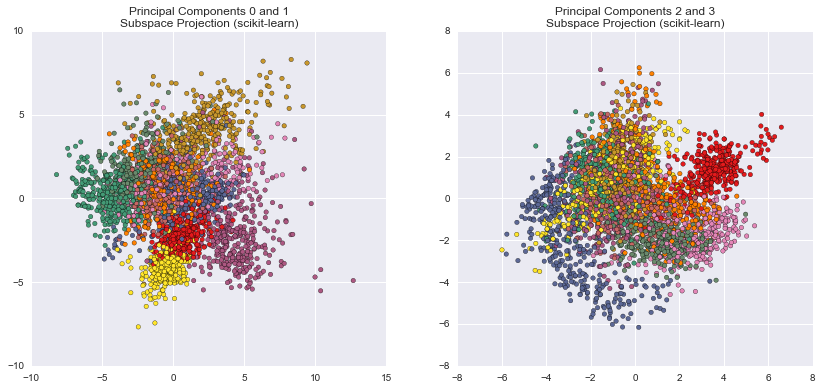

Explained Variance, Principal Component 0: 0.3279
Explained Variance, Principal Component 1: 0.2963
Explained Variance, Principal Component 2: 0.2149
Explained Variance, Principal Component 3: 0.1609


In [30]:
fig = plt.figure(figsize=(14,6))
ax1, ax2 = [fig.add_subplot(120 + i + 1) for i in range(2)]

# To color each point by the digit it represents,
# create a color map with 10 elements (10 RGB values).
# Then, use the system response (y_training), which conveniently
# is a digit from 0 to 9.
def get_cmap(n):
    #colorz = plt.cm.cool
    colorz = plt.get_cmap('Set1')
    return[ colorz(float(i)/n) for i in range(n)]

colorz = get_cmap(10)
colors = [colorz[yy] for yy in y_training]

ax1.scatter( scikit_Z[:,0], scikit_Z[:,1] , c=colors )
ax1.set_title('Principal Components 0 and 1\nSubspace Projection (scikit-learn)')

ax2.scatter( scikit_Z[:,2], scikit_Z[:,3] , c=colors )
ax2.set_title('Principal Components 2 and 3\nSubspace Projection (scikit-learn)')

plt.show()

for i in range(4):
    print("Explained Variance, Principal Component %d: %0.4f"%(i,sklearn_pca.explained_variance_[i]/np.sum(sklearn_pca.explained_variance_.sum())))

### Assessing a PCA Model: Reconstruction Error and Back-Projection

We've projected the original high-dimensional inputs into a lower-dimensional subspace, using the projection matrix:

$$
\mathbf{Z} = \mathbf{W}^{T} \mathbf{X}
$$

It is possible to assess how good the model is by using back-projection, to transform the low-dimensional inputs back into high-dimensional space, with some loss of information. The back-projected set of high-dimensional inputs is denoted $\hat{\mathbf{X}}$:

$$
\hat{\mathbf{X}} = \mathbf{W} \mathbf{Z}
$$

Note that this utilizes the fact that $\mathbf{W W}^{T} = \mathbf{I}$, as implemented in the optimization constraints. The Euclidian distance between the original and the back-projected points provides a measure of how much information was lost:

$$
\| \hat{\mathbf{X}} - \mathbf{X} \|^2
$$

By visually comparing the original and back-projected inputs, we can visually examine what information is lost, and how much, by using `imshow()` to show the original and back-projected data.

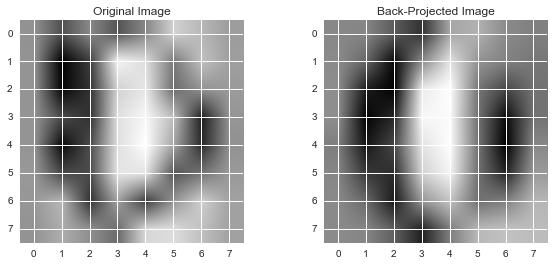

In [31]:
X_digit1 = X_std[0]
Z_digit1 = X_digit1.dot(matW)
Xhat_digit1 = Z_digit1.dot(matW.T)

fig = plt.figure(figsize=(10,4))
ax1, ax2 = (fig.add_subplot(121+i) for i in range(2))

ax1.imshow(X_digit1.reshape(8,8))
ax1.set_title('Original Image')

ax2.imshow(Xhat_digit1.reshape(8,8))
ax2.set_title('Back-Projected Image')

plt.show()

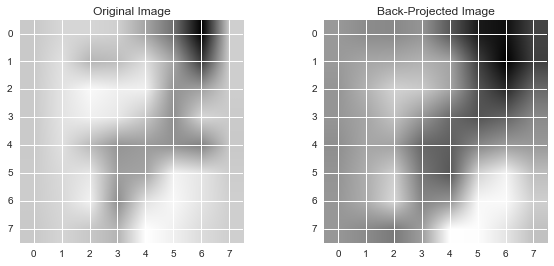

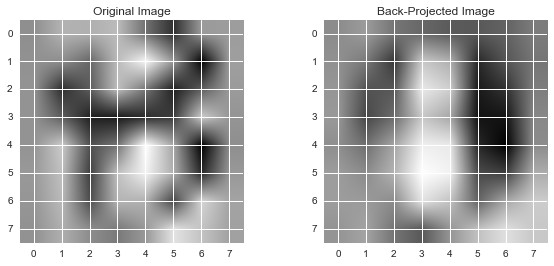

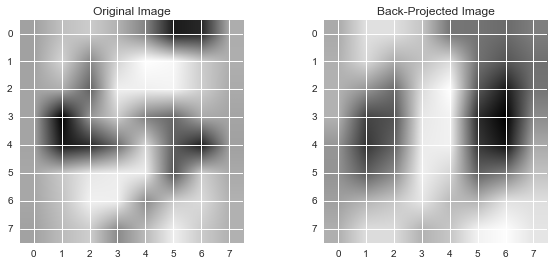

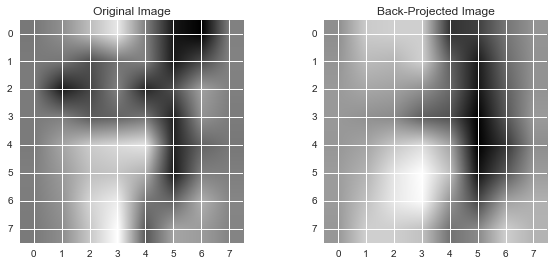

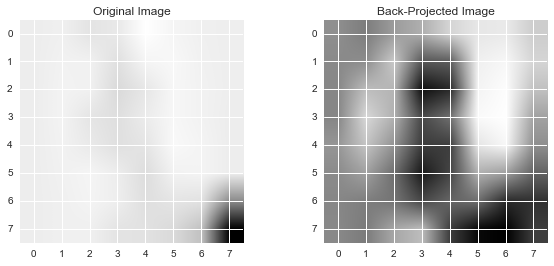

In [32]:
for j in range(5):
    X_digit = X_std[j+20]
    Z_digit = X_digit.dot(matW)
    Xhat_digit = Z_digit.dot(matW.T)

    fig = plt.figure(figsize=(10,4))
    ax1, ax2 = (fig.add_subplot(121+i) for i in range(2))

    ax1.imshow(X_digit.reshape(8,8))
    ax1.set_title('Original Image')

    ax2.imshow(Xhat_digit.reshape(8,8))
    ax2.set_title('Back-Projected Image')

plt.show()

In [36]:
(Xhat_digit1 - X_digit1)**2

array([  0.00000000e+00,   6.06473886e-01,   8.81793420e-02,
         4.60435005e-04,   1.44955582e-01,   1.98420876e-01,
         1.45998014e-01,   4.43792770e-02,   2.01607589e-06,
         1.82327160e+00,   3.37845283e-03,   2.00832724e+00,
         7.56312238e-03,   1.56241837e-01,   3.58084181e-01,
         9.26301373e-02,   1.29535194e-04,   4.60621582e-01,
         2.06128976e-03,   3.72082888e-02,   5.07767533e-02,
         1.00116564e-01,   3.63798964e-01,   1.02007302e-01,
         8.77281216e-04,   6.54816591e-02,   9.22816644e-02,
         3.70388448e-02,   4.91210593e-02,   4.63763140e-01,
         6.10407951e-02,   5.83054045e-02,   1.40748748e-02,
         3.45916567e-01,   7.06275601e-02,   1.05242106e-02,
         1.33304453e-01,   1.38220168e-01,   4.22733281e-04,
         0.00000000e+00,   1.21716443e-02,   4.35531956e-02,
         5.60930647e-03,   1.87704391e-01,   6.32429124e-03,
         2.96997247e-01,   2.34793514e-01,   4.47161609e-03,
         2.46465070e-03,

## Conclusion

This notebook shows some of the implementation details of a PCA model. Further variations are possible, particularly for classification data, such as the NIST digit classification data set. Karhunen-Loéve expansion uses class information, for example, by computing separate class covariance matrices and averaging them. Common principal components finds principal components that are common to each class, but uses different covariances for different classes. This allows for regularization - forcing a model away from overfitting data.